# House Price Prediction

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In this assignment, we're going to try to use all the features in our dataset to improve our model. This means that we'll have to do a more careful cleaning of the dataset.

# Import Data

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [3]:
california_df = pd.DataFrame(housing.data,
                             columns=housing.feature_names)
california_df['MedHouseValue'] = pd.Series(housing.target)
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Exploratory Data Analysis

In [4]:
california_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  float64
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   MedHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


We can see that there are no missing values in the dataset and all the columns are of numeric data type.

In [5]:
california_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Using the decribe() method the result we obtained shows many extreme values which needs to be taken care of. These extreme values are known as outliers.

In [6]:
corr=california_df.corr()
corr

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseValue,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


<Axes: >

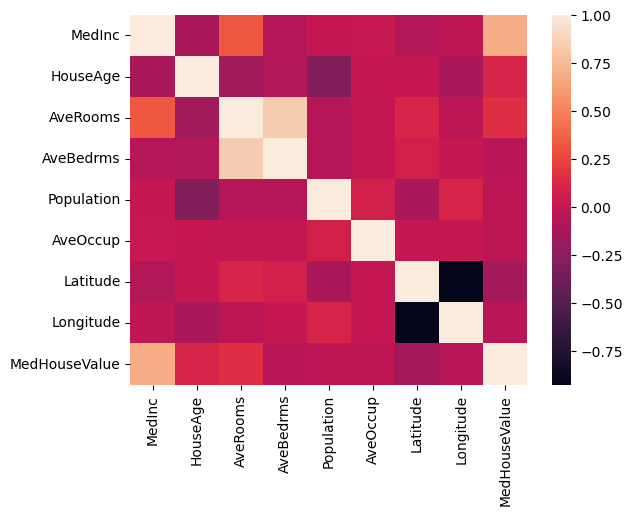

In [7]:
sns.heatmap(corr)

We can see that the "AveRooms" and "AveBedrms" are highly correlated. So one of these two features needs to be dropped.

# wrangle() function definition for data cleaning

We will write a function named wrangle() that takes a Dataframe as an argument and returns a cleaned DataFrame where all the outliers are removed, feature selection is done and missing values taken care of. This function is written to automate our cleaning process.

In [8]:
def wrangle(df):
    # Subset data: Remove outliers for the dataframe using IQR
    for col in df.select_dtypes(include=np.number):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[
        (df[col] >= lower_bound) & (df[col] <= upper_bound)]
    # Drop features with multi-collinearity
    df.drop(columns="AveRooms", inplace=True)
    
    return df
    

In [9]:
df=wrangle(california_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232 entries, 3 to 20639
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         16232 non-null  float64
 1   HouseAge       16232 non-null  float64
 2   AveBedrms      16232 non-null  float64
 3   Population     16232 non-null  float64
 4   AveOccup       16232 non-null  float64
 5   Latitude       16232 non-null  float64
 6   Longitude      16232 non-null  float64
 7   MedHouseValue  16232 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [10]:
df.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000
mean,3.648737,29.413011,1.046886,1278.902292,2.868542,35.669639,-119.623566,1.916735
std,1.435056,12.187341,0.065829,633.567975,0.626150,2.141406,1.995380,0.930086
min,0.536000,1.000000,0.869822,5.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.559200,19.000000,1.002732,817.000000,2.440251,33.940000,-121.810000,1.183000
50%,3.487150,30.000000,1.043478,1164.000000,2.817387,34.290000,-118.600000,1.768500
75%,4.569950,38.000000,1.088379,1644.000000,3.248209,37.730000,-118.030000,2.480000
max,8.011300,52.000000,1.232975,3183.000000,4.571046,41.950000,-114.570000,4.676000


In [11]:
corr=df.corr()
corr

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
MedInc,1.000000,-0.182531,-0.259993,-0.002915,-0.032088,-0.075565,-0.012836,0.630706
HouseAge,-0.182531,1.000000,-0.070692,-0.275479,-0.002030,0.004134,-0.088029,0.085420
AveBedrms,-0.259993,-0.070692,1.000000,0.085638,-0.086528,0.034884,-0.003888,-0.099329
Population,-0.002915,-0.275479,0.085638,1.000000,0.207743,-0.112683,0.105164,-0.004531
AveOccup,-0.032088,-0.002030,-0.086528,0.207743,1.000000,-0.167440,0.186777,-0.274968
Latitude,-0.075565,0.004134,0.034884,-0.112683,-0.167440,1.000000,-0.933307,-0.149929
Longitude,-0.012836,-0.088029,-0.003888,0.105164,0.186777,-0.933307,1.000000,-0.044591
MedHouseValue,0.630706,0.085420,-0.099329,-0.004531,-0.274968,-0.149929,-0.044591,1.000000


<Axes: >

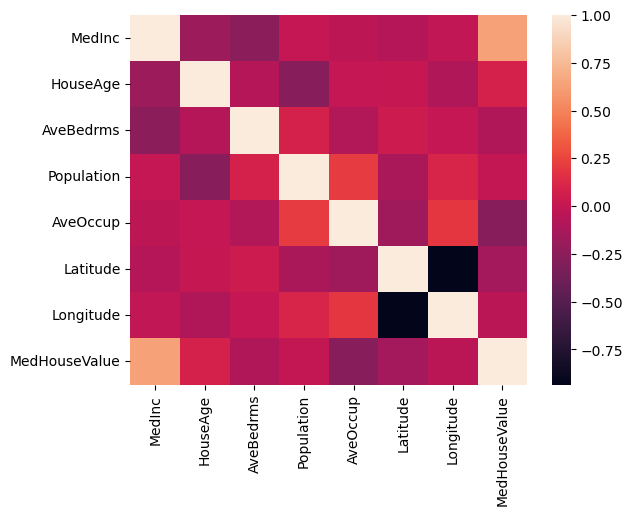

In [12]:
sns.heatmap(corr)

We can see that our data cleaning has been done. Now we will split our dataframe to features and target variable

# Split Data

In [13]:
# Features
X = df.drop('MedHouseValue', axis=1)
# Target
y = df['MedHouseValue']

In [14]:
y.shape

(16232,)

In [15]:
X.shape

(16232, 7)

Now we split our features and target to training and test set which is a very crucial step to training and testing the model.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

In [17]:
X_train.shape

(12985, 7)

In [18]:
X_test.shape

(3247, 7)

# Build Model

## Baseline

The first step in building a model is baselining. We do this to check if the model we build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of any changes in features of the house. So let's start by figuring out what our baseline model's prediction should be.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_mean=y_train.mean()
print("Mean apt price:", round(y_mean,2))
y_pred_baseline=[y_mean]* len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_pred_baseline))
print(f"RMSE: {rmse}")

# Calculate R²
r2 = r2_score(y_train, y_pred_baseline)
print(f"R²: {r2}")

Mean apt price: 1.92
Baseline MAE: 0.7555052459363006
RMSE: 0.9337725487747731
R²: 0.0


What does this information tell us? If we always predicted that an apartment price is $(1.92)*100000, our predictions would be off by an average of $(0.755505) * 100000 . It also tells us that our model needs to have mean absolute error below $(0.755505)*100000 in order to be useful. Low RMSE suggests that the model fits the data well. R² value ranges from 0 to 1, where 1 means a perfect fit.

## Instantiate DecisionTreeRegressor model

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

## Evaluate

In [21]:
training_mae = mean_absolute_error(y_train, tree_model.predict(X_train))
test_mae = mean_absolute_error(y_test,tree_model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.0
Test MAE: 0.4


Good news: Our model beat the baseline on both the training and the test set.

In [22]:

# Predict on the test set
y_pred = tree_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

RMSE: 0.6011260029015274
R²: 0.5684324482989382


Our model beat the baseline model based on RMSE and R² score.

## Communicate Results

In [23]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test, 
        "y_pred":tree_model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
7794,1.536,1.659
9480,0.715,0.715
9273,4.232,2.919
11949,1.141,1.213
13831,1.678,1.620


# Optimize model using GridSearchCV

The GridSearchCV class automates the process of hyperparameter tuning for a machine learning model. It systematically evaluates a model with different combinations of hyperparameters specified in a 'param_grid' dictionary.

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the DecisionTreeRegressor
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_absolute_error')

In [25]:
# Get the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (MAE):", -grid_search.best_score_)

# Evaluate the best model on the test set
best_tree_model = grid_search.best_estimator_
test_mae = mean_absolute_error(y_test, best_tree_model.predict(X_test))
print("Test MAE with best model:", test_mae)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score (MAE): 0.36400785098530697
Test MAE with best model: 0.3491112262006023


In [26]:
# Predict on the test set
y_pred = best_tree_model.predict(X_test)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

RMSE: 0.5059210873149516
R²: 0.6943085317513276


The DecisionTreeRegressor model optimized using GridSearchCV beat the DecisionTreeRegressor based on MAE, RMSE and R² score

In [27]:
best_tree_model.predict(np.array([[8.3252, 41.0, 1.023810, 322.0, 2.555556, 37.88, -122.23]]))

array([3.753])

##  Save the trained model using Joblib

In [28]:
import joblib

# Save the best model
joblib.dump(best_tree_model, 'best_tree_model.pkl') 

['best_tree_model.pkl']